# Feature Engineering

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


Read in the CSV from the DataPreprocessing

In [123]:
data = pd.read_csv("Preprocessed_Data.csv")

### Splitting the dataset to Train and Test

We begin by splitting the dataset into training, validation, and test sets. This ensures that any transformations applied later do not leak information from one split to another.
We also keep a copy of the splitted dataset, so that we can later compare the performance of some models based on the raw dataset and the new dataset including the newly added features.


In [124]:
train_df, test_df = train_test_split(
    data, test_size=0.2, random_state=42
)

train_df_raw = train_df.copy()
test_df_raw = test_df.copy()

### Transforming the Target Variable to have a unique base

After the split, we normalize the target variable in the training set by dividing the total comment volume by the prediction horizon H_Local, resulting in a consistent comments per hour metric.

Our analysis showed that raw comment counts are heavily influenced by the length of the observation window—longer windows naturally accumulate more comments. This creates a bias that makes it difficult to compare engagement levels across samples with different horizons.

By normalizing the target, we remove this dependency on window length. This allows the model to learn more general engagement patterns, improving both training stability and prediction accuracy.

In [125]:
train_df['Hourly_Target_Volume'] = train_df['Target_Comment_Volume'] / train_df['H_Local']

### Add Feature: Comment Section Turned Off

A new binary feature is added to indicate whether the comment section is likely turned off.

Our data analysis revealed that some posts—particularly from pages with high levels of engagement (e.g., many likes or page check-ins)—consistently had **no recorded comments**, despite being otherwise active. This pattern suggests that for certain posts, the **comment section may have been intentionally disabled**.

To capture this, we define a heuristic:  
If a post has a high number of shares (above the 25th percentile) but **zero tracked comments**, we flag it as having the comment section turned off.

The 25th percentile threshold for shares is calculated from the **training dataset** and is applied consistently to both the training and test datasets to ensure alignment and prevent data leakage.

In [126]:
share_thresh = np.percentile(train_df['Post_Share_Count'], 25)

mask_time_enough = train_df['Base_Time'] >= 10
mask_no_comments = train_df['CC1_Total_Comments'] == 0
mask_high_share  = train_df['Post_Share_Count']      > share_thresh

train_df['Comments_Section_Off'] = 0
train_df.loc[
    mask_time_enough & mask_no_comments & mask_high_share,
    'Comments_Section_Off'
] = 1

mask_time_enough = test_df['Base_Time'] >= 10
mask_no_comments = test_df['CC1_Total_Comments'] == 0
mask_high_share  = test_df['Post_Share_Count']      > share_thresh

test_df['Comments_Section_Off'] = 0
test_df.loc[
    mask_time_enough & mask_no_comments & mask_high_share,
    'Comments_Section_Off'
] = 1

### Add Features: Hourly Rates for Past Comment Values

From our data analysis, we observed that a maximum of **72 hours** of comment data was recorded per post. The actual number of recorded hours varies and is indicated by the `Base_Time` column.

This variability introduces inconsistency in the CC1–CC4 features, which represent comment volumes over different historical windows:

- **CC1_Total_Comments**: All past comments up to `Base_Time`
- **CC2_Comments_Last_24h**: Comments from the last 24 hours
- **CC3_Comments_48_to_24h**: Comments from 24–48 hours ago
- **CC4_Comments_First_24h**: Comments from 48–72 hours ago

If `Base_Time` is less than the time window a feature is supposed to represent, the value becomes **incomplete and misleading**.  
For example:
- If `Base_Time` = 24, then both "first 24h" and "last 24h" cover the same period.
- If `Base_Time` = 5, then "last 24h" only includes 5 hours of data—not a full 24—making it incomparable to posts with a full 24-hour window.

To correct for this and ensure consistency, we transform these absolute comment counts into **comments per hour**. This normalization adapts each value to the actual time window it covers, allowing for fair comparison across samples.

We apply this logic to each CC feature by dividing by the effective number of hours available:
- For CC1: divide by `Base_Time`
- For CC2: divide by `min(24, Base_Time)`
- For CC3: divide by `min(24, Base_Time - 24)`
- For CC4: divide by `min(24, Base_Time - 48)`

This approach creates four new features: `Hourly_Rate_CC1` to `Hourly_Rate_CC4`, each representing the **average comment rate per hour** for their respective time segments.


In [127]:

train_df['Hourly_Rate_CC1'] = (
    train_df['CC1_Total_Comments']
    / np.maximum(train_df['Base_Time'], 1)
)
test_df['Hourly_Rate_CC1'] = (
    test_df['CC1_Total_Comments']
    / np.maximum(test_df['Base_Time'], 1)
)

train_df['Hourly_Rate_CC2'] = (
    train_df['CC2_Comments_Last_24h']
    / np.maximum(np.minimum(24, train_df['Base_Time']), 1)
)
test_df['Hourly_Rate_CC2'] = (
    test_df['CC2_Comments_Last_24h']
    / np.maximum(np.minimum(24, test_df['Base_Time']), 1)
)

train_df['Hourly_Rate_CC3'] = (
    train_df['CC3_Comments_48_to_24h']
    / np.maximum(
        np.minimum(24, train_df['Base_Time'] - 24),
        1
    )
)
test_df['Hourly_Rate_CC3'] = (
    test_df['CC3_Comments_48_to_24h']
    / np.maximum(
        np.minimum(24, test_df['Base_Time'] - 24),
        1
    )
)

train_df['Hourly_Rate_CC4'] = (
    train_df['CC4_Comments_First_24h']
    / np.maximum(
        np.minimum(24, train_df['Base_Time'] - 48),
        1
    )
)
test_df['Hourly_Rate_CC4'] = (
    test_df['CC4_Comments_First_24h']
    / np.maximum(
        np.minimum(24, test_df['Base_Time'] - 48),
        1
    )
)


### Add Features: Binned Target Means for Continuous Page Attributes

For each of the continuous page-level features:

- `Page_Popularity_Likes`
- `Page_Checkins`
- `Page_Talking_About`

we create new features that capture the **average target behavior across value ranges (bins)** of each variable.

**How it works:**

- In the training data, each feature is split into 30 quantile-based bins (`qcut`), ensuring balanced distribution.
- For each bin, we calculate the average `Hourly_Target_Volume`.
- This average is then mapped back as a new feature (e.g., `Page_Popularity_Likes_Bin_Target_Mean`), reflecting the typical engagement level for similar value ranges.
- These bin definitions and mean values are stored and then applied to the test data using `pd.cut`, ensuring consistency and avoiding data leakage.

**Why we added it:**

This transformation allows the model to leverage **nonlinear relationships** between continuous features and the target variable, while preserving interpretability. It smooths out noise and helps the model focus on broader patterns within value ranges rather than overfitting to raw numeric scales.


In [128]:

cont_feats = ['Page_Popularity_Likes', 'Page_Checkins', 'Page_Talking_About']
bin_edges = {}
bin_means = {}

for feat in cont_feats:
    bin_col   = feat + '_bin'
    mean_col  = feat + '_Bin_Target_Mean'

    train_df[bin_col] = pd.qcut(
        train_df[feat], q=30, duplicates='drop'
    )
    bmean = train_df.groupby(bin_col)['Hourly_Target_Volume'].mean()
    train_df[mean_col] = train_df[bin_col].map(bmean)
    bin_edges[feat] = train_df[bin_col].cat.categories
    bin_means[feat] = bmean
    train_df.drop(columns=[bin_col], inplace=True)

    test_df[bin_col] = pd.cut(
        test_df[feat],
        bins=bin_edges[feat]
    )
    test_df[mean_col] = test_df[bin_col].map(bin_means[feat])
    test_df.drop(columns=[bin_col], inplace=True)

### Add Feature: Trend Ratio
This is a Ratio of Past to Future Comment Rate (Aggregate-Based)

This feature represents the average ratio between a post’s recent past comment rate (last 24 hours) and its future comment rate. It is calculated by first computing individual future-to-past ratios in the training set, then averaging these within 100 quantile bins based on `Hourly_Rate_CC2` (comments per hour in the last 24h).

**Why we use bins:**  
Since we cannot use target values in the test dataset, we use the binned past activity (`Hourly_Rate_CC2`) to assign an average future-to-past ratio learned from the training data. This allows us to estimate future engagement in the test set using only features available at prediction time.

**Why it’s important:**  
It captures how typical it is for posts with a certain level of recent activity to continue receiving comments. This helps the model better estimate future comment volume based on historical engagement dynamics.


In [129]:
future_rate = train_df['Hourly_Target_Volume']
past_rate   = train_df['Hourly_Rate_CC2']

train_df['Ratio_Indiv'] = np.where(
    past_rate == 0,
    0,
    future_rate / past_rate
)

train_df.loc[train_df['Comments_Section_Off'] == 1, 'Ratio_Indiv'] = np.nan

train_df['CC2_ratio_bin'] = pd.qcut(
    train_df['Hourly_Rate_CC2'],
    q=50,
    duplicates='drop'
)

ratio_group = (
    train_df
    .groupby('CC2_ratio_bin')['Ratio_Indiv']
    .mean()
    .reset_index()
    .rename(columns={'Ratio_Indiv': 'Ratio_Agg_Past24h_vs_Future'})
)

train_df = train_df.merge(ratio_group, on='CC2_ratio_bin', how='left')
train_df.loc[train_df['Comments_Section_Off'] == 1, 'Ratio_Agg_Past24h_vs_Future'] = 0

ratio_bins = train_df['CC2_ratio_bin'].cat.categories
train_df.drop(columns=['Ratio_Indiv', 'CC2_ratio_bin'], inplace=True)


test_df['CC2_ratio_bin'] = pd.cut(
    test_df['Hourly_Rate_CC2'],
    bins=ratio_bins
)

test_df = test_df.merge(ratio_group, on='CC2_ratio_bin', how='left')

test_df['Ratio_Agg_Past24h_vs_Future'] = test_df['Ratio_Agg_Past24h_vs_Future'].fillna(0)
test_df.loc[test_df['Comments_Section_Off'] == 1, 'Ratio_Agg_Past24h_vs_Future'] = 0

test_df.drop(columns=['CC2_ratio_bin'], inplace=True)

Drop the Hourly Target Volume - which we used for the calculation of the features - so that we dont accidently use this as a feature for our model training later

In [130]:
train_df = train_df.drop(['Hourly_Target_Volume'], axis=1)

### Correlation Heatmap with new features
Now we want to see the correlation of the newly added features with our target variable. For this, we run the correlation on the test dataset, to see how well the features correlate based on our calcuations that did not leak the target variable of the test dataset.

We can see that expecially our sanitzied Hourly Comment Rate have a very strong correlation with the target variable, stronger than any other of the original pure dataset.

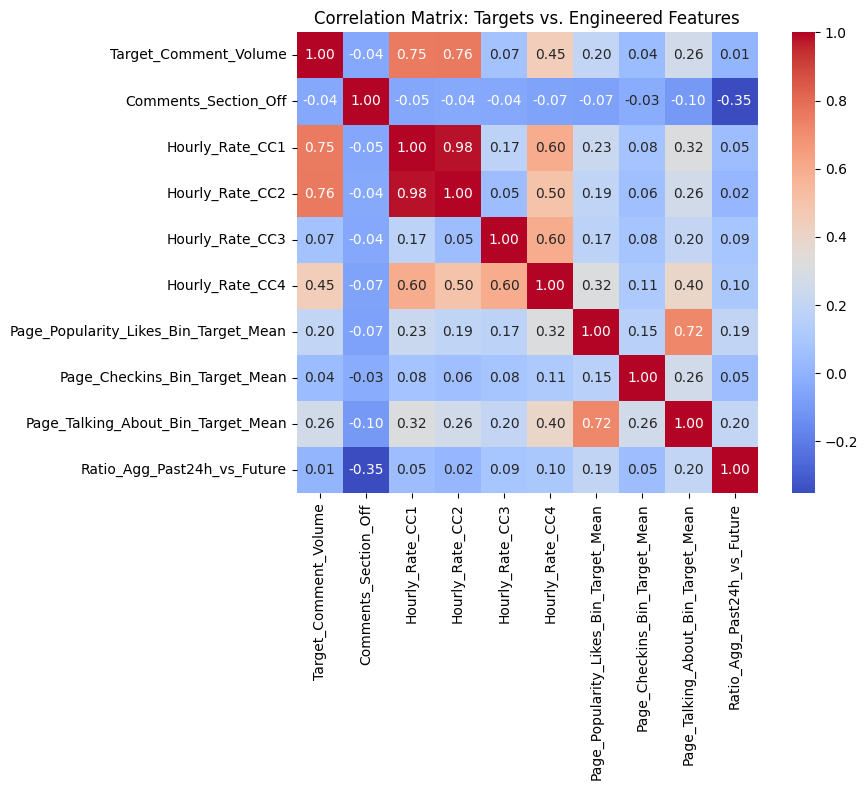

In [131]:
corr_cols = [
    'Target_Comment_Volume',
    'Comments_Section_Off',
    'Hourly_Rate_CC1',
    'Hourly_Rate_CC2',
    'Hourly_Rate_CC3',
    'Hourly_Rate_CC4',
    'Page_Popularity_Likes_Bin_Target_Mean',
    'Page_Checkins_Bin_Target_Mean',
    'Page_Talking_About_Bin_Target_Mean',
    'Ratio_Agg_Past24h_vs_Future'
]


corr_matrix = test_df[corr_cols].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix: Targets vs. Engineered Features")
plt.tight_layout()
plt.show()

Now we devide our train and test data into our X and y, to run training on some simple methods to see first results.

In [132]:
X_train      = train_df.drop(columns='Target_Comment_Volume')
y_train      = train_df['Target_Comment_Volume']

X_test       = test_df.drop(columns='Target_Comment_Volume')
y_test       = test_df['Target_Comment_Volume']

X_train_raw  = train_df_raw.drop(columns='Target_Comment_Volume')
y_train_raw  = train_df_raw['Target_Comment_Volume']

X_test_raw   = test_df_raw.drop(columns='Target_Comment_Volume')
y_test_raw   = test_df_raw['Target_Comment_Volume']


In [133]:
train_df.to_csv("train_df.csv", index=False)
test_df.to_csv("test_df.csv", index=False)

### Simple Baseline Model: Scaled Past Rate with Learned Ratio

This baseline model predicts the future number of comments using a simple, interpretable formula:

**Prediction = Past Hourly Rate × Future Time Window × Trend Ratio**

Specifically, it multiplies:
- `Hourly_Rate_CC2`: the recent comment rate (last 24 hours),
- `H_Local`: the number of future hours to predict,
- `Ratio_Agg_Past24h_vs_Future`: a learned adjustment factor that reflects how recent activity typically translates into future engagement.

**Why this works:**  
This model leverages recent comment trends and adjusts them based on historical behavior patterns learned from the training data. It's a lightweight, explainable benchmark that gives a solid starting point for evaluating more complex models.

In [134]:
def simple_predict(df):
    return df['Hourly_Rate_CC2'] * df['H_Local'] * df['Ratio_Agg_Past24h_vs_Future']

y_pred = simple_predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

Mean Absolute Error (MAE): 4.50
Mean Squared Error (MSE): 499.42


### Experiment: Decision Tree and Linear Model on original dataset
Now we want to conduct first tests, to see if our features have a positive impact on model. Therefore we train a simple model on the raw data, and the data extended with out features.

In [135]:
dt_raw = DecisionTreeRegressor(random_state=42)
dt_raw.fit(X_train_raw, y_train_raw)

y_pred_raw = dt_raw.predict(X_test_raw)
mae = mean_absolute_error(y_test_raw, y_pred_raw)
mse = mean_squared_error(y_test_raw, y_pred_raw)

print("Decision Tree on Raw Original Data")
print(f"  MAE: {mae:.2f}")
print(f"  MSE: {mse:.2f}")

lr_raw = LinearRegression()
lr_raw.fit(X_train_raw, y_train_raw)

y_pred_lr = lr_raw.predict(X_test_raw)
mae_lr = mean_absolute_error(y_test_raw, y_pred_lr)
mse_lr = mean_squared_error(y_test_raw, y_pred_lr)

print("Linear Regression on Raw Original Data")
print(f"  MAE: {mae_lr:.2f}")
print(f"  MSE: {mse_lr:.2f}")

Decision Tree on Raw Original Data
  MAE: 5.71
  MSE: 957.41
Linear Regression on Raw Original Data
  MAE: 8.23
  MSE: 675.78


### Experiment: Decision Tree and Linear Regression on dataset with newly added features
The prediction results are significantly better with our newly constructed features: Especially the MSE dropped, meaning there are less "very off" predictions

In [136]:
dt_orig = DecisionTreeRegressor(random_state=42)
dt_orig.fit(X_train, y_train)
y_pred_orig = dt_orig.predict(X_test)

mae_orig = mean_absolute_error(y_test, y_pred_orig)
mse_orig = mean_squared_error(y_test, y_pred_orig)
r2_orig = r2_score(y_test, y_pred_orig)

print("Decision Tree on Data with new Features")
print(f"  MAE: {mae_orig:.2f}")
print(f"  MSE: {mse_orig:.2f}")
print(f"  R²:  {r2_orig:.2f}\n")

lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)

y_pred_lr = lr_raw.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print("Linear Regression on Data with new Features")
print(f"  MAE: {mae_lr:.2f}")
print(f"  MSE: {mse_lr:.2f}")
print(f"  R²:  {r2_lr:.2f}")

Decision Tree on Data with new Features
  MAE: 5.34
  MSE: 704.43
  R²:  0.34

Linear Regression on Data with new Features
  MAE: 5.93
  MSE: 419.59
  R²:  0.61



## Exemplary Feature Selection:


### Feature Selection with RFECV and Model Evaluation

This process uses **Recursive Feature Elimination with Cross-Validation (RFECV)** to identify the most relevant features for predicting comment volume.

- A **Linear Regression** model is used to rank features based on importance.
- Features are removed one at a time, and 5-fold cross-validation is used to evaluate performance (MSE).
- The optimal number of features is selected by minimizing validation error.

After selecting the best subset of features, two models — **Linear Regression** and **Decision Tree Regressor** — are trained and evaluated on the reduced feature set using MAE and MSE.

This helps identify a compact, high-performing feature set and compare model performance on it.


Optimal feature count: 118
Selected features: ['Derived_1', 'Derived_3', 'Derived_4', 'Derived_5', 'Derived_6', 'Derived_8', 'Derived_10', 'Derived_11', 'Derived_12', 'Derived_13', 'Derived_14', 'Derived_15', 'Derived_16', 'Derived_18', 'Derived_19', 'Derived_23', 'Derived_24', 'Derived_25', 'CC1_Total_Comments', 'CC2_Comments_Last_24h', 'CC3_Comments_48_to_24h', 'CC4_Comments_First_24h', 'CC5_CC2_CC3_Difference', 'Base_Time', 'H_Local', 'Page_Category_Album', 'Page_Category_App page', 'Page_Category_Artist', 'Page_Category_Arts/entertainment/nightlife', 'Page_Category_Arts/humanities website', 'Page_Category_Athlete', 'Page_Category_Author', 'Page_Category_Bar', 'Page_Category_Book', 'Page_Category_Business/economy website', 'Page_Category_Camera/photo', 'Page_Category_Cars', 'Page_Category_Cause', 'Page_Category_Church/religious organization', 'Page_Category_Clothing', 'Page_Category_Club', 'Page_Category_Comedian', 'Page_Category_Community', 'Page_Category_Company', 'Page_Category_C

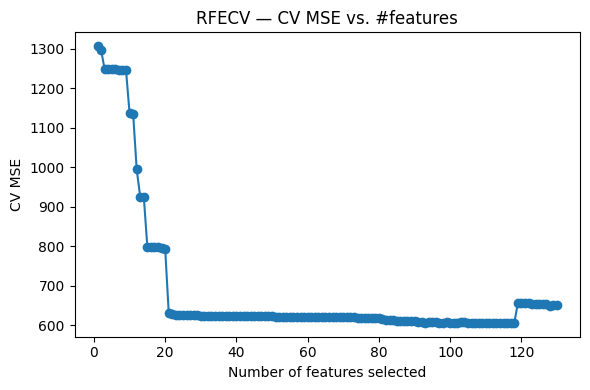

LinearRegression on RFECV features — MAE: 5.87, MSE: 423.37
DecisionTreeRegressor on RFECV features — MAE: 5.78, MSE: 969.22


In [137]:
from sklearn.feature_selection import RFECV

est = LinearRegression()

rfecv = RFECV(
    estimator=est,
    step=1,
    cv=5,
    scoring='neg_mean_squared_error',
    min_features_to_select=1,
    n_jobs=-1
)
rfecv.fit(X_train, y_train)

opt_n = rfecv.n_features_
print("Optimal feature count:", opt_n)
selected = X_train.columns[rfecv.support_]
print("Selected features:", list(selected))

mse_scores = -rfecv.cv_results_['mean_test_score']

plt.figure(figsize=(6,4))
plt.plot(
    np.arange(1, len(mse_scores) + 1),
    mse_scores,
    marker='o'
)
plt.xlabel("Number of features selected")
plt.ylabel("CV MSE")
plt.title("RFECV — CV MSE vs. #features")
plt.tight_layout()
plt.show()

X_tr_rfecv = rfecv.transform(X_train)
X_te_rfecv = rfecv.transform(X_test)

for Model in (LinearRegression, DecisionTreeRegressor):
    m = Model().fit(X_tr_rfecv, y_train)
    pred = m.predict(X_te_rfecv)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    print(f"{Model.__name__} on RFECV features — MAE: {mae:.2f}, MSE: {mse:.2f}")

### Feature Selection with Sequential Floating Forward Selection (SFS)

This approach uses **Sequential Floating Forward Selection (SFS)** to automatically identify the best subset of features for predicting comment volume.

- A **Linear Regression** model is used as the base estimator.
- Features are added iteratively in a forward fashion, with the option to remove previously added features if they become less useful (floating).
- The number of features is determined automatically by optimizing cross-validated performance (MSE).

After selecting the optimal features, both **Linear Regression** and **Decision Tree Regressor** models are trained and evaluated on the reduced feature set using MAE and MSE.

This method offers a more flexible and potentially more accurate alternative to standard forward selection.

Due to resource constaints, we only selected the top 20 features (setting this to auto takes too much time). With this setup, especially the performance of the Decision tree is further improved

In [138]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


sfs = SFS(
    estimator=LinearRegression(),
    k_features=20,
    forward=True,
    floating=True,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)
sfs = sfs.fit(X_train.values, y_train.values)

feat_idx = list(sfs.k_feature_idx_)
feat_names = X_train.columns[feat_idx]
print("Best #features:", len(feat_idx))
print("Selected features:", feat_names)

X_tr = sfs.transform(X_train.values)
X_te = sfs.transform(X_test.values)

for Model in (LinearRegression, DecisionTreeRegressor):
    m = Model().fit(X_tr, y_train)
    pred = m.predict(X_te)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    print(f"{Model.__name__} — MAE: {mae:.2f}, MSE: {mse:.2f}")

Best #features: 20
Selected features: Index(['Page_Checkins', 'Derived_4', 'Derived_5', 'Derived_8', 'Derived_14',
       'Derived_19', 'Derived_20', 'CC2_Comments_Last_24h',
       'CC3_Comments_48_to_24h', 'CC4_Comments_First_24h', 'Base_Time',
       'H_Local', 'Page_Category_Album', 'Page_Category_Movie',
       'Page_Category_Political party', 'Page_Category_Writer',
       'Comments_Section_Off', 'Hourly_Rate_CC2',
       'Page_Talking_About_Bin_Target_Mean', 'Ratio_Agg_Past24h_vs_Future'],
      dtype='object')
LinearRegression — MAE: 5.84, MSE: 427.97
DecisionTreeRegressor — MAE: 5.05, MSE: 652.14


Exception ignored in: <function ResourceTracker.__del__ at 0x105956b60>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1047e2b60>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi

### Conclusion:

Both Feature Selection Methods selected a large amount of the newly added features, suggested that the Data Analysis helped us derive insights from which we could engineer new features that leverage the models performance by making important information more explicit.

As there is not one unique solution for Feature Selection, and this can be tailored for different models based on what their strenghts are, we implemented some Feature Selection techniques in the Model Implementation itself

### Further Ideas
**Aggregate Categories**: Right now we have more than 100 values for the columns Page_Category. This increases our dimensionality a lot due to the One Hot Encoding. An approach to solve this with Feature Engineering would be to aggregate certain categories to Parent Categories

**Reverse Engineer the Derived Features**: This could give us more insights into the data and what these features represent, to either derive further insights, or make informed decision f.e. whether we can drop a column or not
